# Implementing and Visualizing a Variational Quantum Classifier for Binary Classification

We are implementing a simple quantum machine learning (QML) model to solve a binary classification problem. The data is two-dimensional (2D) and can be classified into two classes labeled as $\{−1, +1\}$.

## Import Necessary Libraries

- `pennylane`: A library for quantum machine learning. It lets us define quantum circuits, take their derivatives, and integrate seamlessly with classical ML code.
- `pennylane.numpy`: A NumPy interface that plays nicely with automatic differentiation.
- `sklearn`: Used to generate and split a synthetic dataset.
- `matplotlib`: For plotting the loss and accuracy over epochs.

In [1]:
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Data Preparation

The labels are converted to $\{−1, +1\}$ because our quantum model’s output (an expectation value of a Pauli-Z measurement) naturally ranges from $-1$ to $+1$.

In [2]:
# Generate a 2D classification dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                           n_redundant=0, n_clusters_per_class=1, random_state=42)

# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels from {0, 1} to {-1, +1}
y_train = 2*y_train - 1
y_test = 2*y_test - 1

## Quantum Device and Circuit Setup

- We choose a 2-qubit quantum simulator (default.qubit device) from PennyLane.
- Each input vector $x = (x_1, x_2)$ will be encoded into the states of these two qubits.

In [3]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

## Parametric Quantum Circuit (Ansatz)

#### Feature Encoding:
We take the classical vector $x = (x_1, x_2)$ and encode it into a quantum state. `AngleEmbedding` uses the given real values as rotation angles about the Y-axis. Initially, a single qubit starts in the state $|0\rangle$. After applying $R_Y(x_1)$ on the first qubit and $R_Y(x_2)$ on the second qubit, the quantum state becomes:

$$
|\psi(x)\rangle = R_Y(x_1)|0\rangle \otimes R_Y(x_2)|0\rangle
$$

In [4]:
def feature_encoding(x):
    # Encode each feature into a qubit's rotation angle.
    # Here we use AngleEmbedding from PennyLane
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')

#### Variational Circuit:
For each layer $l$:
- We apply rotations $R_X(\theta_{l,i,1}),\: R_Y(\theta_{l,i,2}),\: \text{and}\:  R_Z(\theta_{l,i,3})$ on the $i$-th qubit, where $\theta_{l,i,j}$ are the parameters in `params`.
- Then we apply entangling CNOT gates to create correlations between qubits.

The final measurement is:
$$
f_\theta(x) = \langle 0| U^\dagger(\theta, x) Z_0 U(\theta, x) |0\rangle^{\otimes n}
$$
where $U(\theta, x)$ represents the entire unitary transformation encoded by the feature embedding and the variational parameters.

This expectation value is a real number in $[-1, +1]$ and serves as our model’s prediction.

In [5]:
def variational_circuit(params, x):
    # Encode features into qubits
    feature_encoding(x)
    
    # params shape: (num_layers, n_qubits, 3)
    # Each qubit in each layer has 3 parameters for RX, RY, and RZ rotations
    for layer_params in params:
        for i, wire_params in enumerate(layer_params):
            qml.RX(wire_params[0], wires=i)
            qml.RY(wire_params[1], wires=i)
            qml.RZ(wire_params[2], wires=i)
        
        # Entangle the qubits with CNOT gates
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i+1])
    
    # Measure expectation value of Pauli-Z on the first qubit
    return qml.expval(qml.PauliZ(0))

The `@qml.qnode` decorator transforms `variational_circuit` into a differentiable function `quantum_model` which we can optimize using PennyLane’s auto-differentiation.

In [6]:
@qml.qnode(dev, interface='autograd')
def quantum_model(params, x):
    return variational_circuit(params, x)

## Loss and Accuracy
- **Loss:** The loss function is defined as:
    $$
      L(\theta) = \frac{1}{N} \sum_{i=1}^{N} \left( f_\theta(x^{(i)}) - y^{(i)} \right)^2
    $$

- **Accuracy:** The prediction is considered correct if $\quad \text{sign}(f_\theta(x)) = y$

In [7]:
def loss(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.stack(predictions)
    # Mean Squared Error: (fθ(x) - y)^2 averaged over the dataset
    return np.mean((predictions - Y)**2)

def accuracy(params, X, Y):
    predictions = [quantum_model(params, x) for x in X]
    predictions = np.sign(np.stack(predictions))
    return np.mean(predictions == Y)

## Parameter Initialization

We start the parameters $\theta$ near zero. This often helps avoid initial problems with gradients.

In [8]:
num_layers = 2
params = 0.01 * np.random.randn(num_layers, n_qubits, 3)

## Optimization

- We use a simple gradient descent optimizer with a 0.1 learning rate.
- We will train for 50 epochs, recording metrics each time.

In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
num_epochs = 50

epoch_list = []
loss_list = []
train_acc_list = []
test_acc_list = []

## Training Loop

#### *How Gradients Are Computed:*

PennyLane uses the **parameter-shift rule** to compute derivatives of expectation values. For a single parameter $\theta$, the derivative is given by:
$$
\frac{\partial}{\partial \theta} \langle Z \rangle = \frac{f\left(\theta + \frac{\pi}{2}\right) - f\left(\theta - \frac{\pi}{2}\right)}{2}
$$
This rule allows us to compute exact gradients of quantum circuits without the need for finite differences for every parameter.

In [10]:
for epoch in range(num_epochs):
    # Update parameters by taking a gradient step on the loss w.r.t. params
    params = opt.step(lambda v: loss(v, X_train, y_train), params)
    current_loss = loss(params, X_train, y_train)
    train_acc = accuracy(params, X_train, y_train)
    test_acc = accuracy(params, X_test, y_test)
    
    epoch_list.append(epoch+1)
    loss_list.append(current_loss)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {current_loss:.4f}, "
          f"Train Acc = {train_acc:.2f}, Test Acc = {test_acc:.2f}")

Epoch 1/50: Loss = 1.8929, Train Acc = 0.42, Test Acc = 0.30
Epoch 2/50: Loss = 1.8862, Train Acc = 0.42, Test Acc = 0.30
Epoch 3/50: Loss = 1.8779, Train Acc = 0.44, Test Acc = 0.30
Epoch 4/50: Loss = 1.8674, Train Acc = 0.45, Test Acc = 0.30
Epoch 5/50: Loss = 1.8537, Train Acc = 0.45, Test Acc = 0.30
Epoch 6/50: Loss = 1.8359, Train Acc = 0.45, Test Acc = 0.30
Epoch 7/50: Loss = 1.8126, Train Acc = 0.45, Test Acc = 0.30
Epoch 8/50: Loss = 1.7821, Train Acc = 0.45, Test Acc = 0.30
Epoch 9/50: Loss = 1.7428, Train Acc = 0.45, Test Acc = 0.30
Epoch 10/50: Loss = 1.6933, Train Acc = 0.44, Test Acc = 0.30
Epoch 11/50: Loss = 1.6326, Train Acc = 0.42, Test Acc = 0.30
Epoch 12/50: Loss = 1.5609, Train Acc = 0.41, Test Acc = 0.30
Epoch 13/50: Loss = 1.4798, Train Acc = 0.41, Test Acc = 0.35
Epoch 14/50: Loss = 1.3921, Train Acc = 0.46, Test Acc = 0.35
Epoch 15/50: Loss = 1.3016, Train Acc = 0.50, Test Acc = 0.40
Epoch 16/50: Loss = 1.2122, Train Acc = 0.51, Test Acc = 0.45
Epoch 17/50: Loss

## Final Results

We evaluate the final performance after training completes.

In [11]:
final_train_acc = accuracy(params, X_train, y_train)
final_test_acc = accuracy(params, X_test, y_test)
print(f"Final Training Accuracy: {final_train_acc:.2f}")
print(f"Final Test Accuracy: {final_test_acc:.2f}")

Final Training Accuracy: 0.89
Final Test Accuracy: 1.00


## Plotting the Results

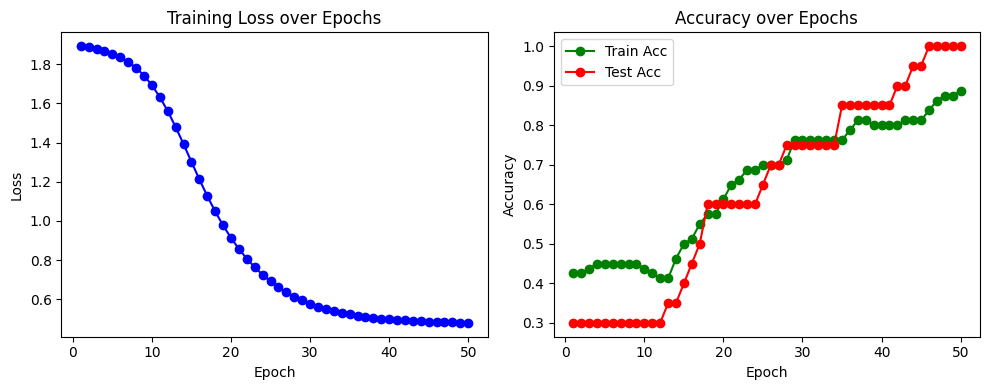

In [12]:
plt.figure(figsize=(10,4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_list, loss_list, marker='o', color='blue')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_acc_list, marker='o', label="Train Acc", color='green')
plt.plot(epoch_list, test_acc_list, marker='o', label="Test Acc", color='red')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates a basic quantum machine learning pipeline: we took a classical dataset, encoded it into a quantum circuit, used a parameterized ansatz to learn decision boundaries, computed gradients of the quantum circuit w.r.t. its parameters, and optimized those parameters to minimize a loss function. We concluded by visualizing and interpreting the training dynamics through plots of loss and accuracy.